# `Setup`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import copy
import datetime as dt
from math import ceil
try:
    # Mounting Colab Drive if possible
    from google.colab import drive
    drive.mount('/content/drive')

    # Cloning repo for colab
    if 'aml_itu' in os.getcwd():
        %cd aml_itu/
        !git pull https://github.com/RasKrebs/aml_itu
    else:
        !git clone https://github.com/RasKrebs/aml_itu
        %cd aml_itu/
    os.environ["COLAB"] = "True"

except:
    # Changing directory into aml_itu
    if os.getcwd().split('/')[-1] != 'aml_itu': os.chdir(os.path.abspath('.').split('aml_itu/')[0]+'aml_itu')
    !git pull origin main --ff-only
    os.environ["COLAB"] = "False"

# Utils Import
from utils.helpers import *
from utils.StatefarmPytorchDataset import StateFarmDataset


# Torch
import torch
from torch.autograd import Variable
from torch import nn
import torchvision
import torchvision.transforms as T
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import math


# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary


# Printing current working directory
print(os.getcwd())

# Setting up device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print (f"GPU is available")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print('MPS device found.')
else:
    print ("No GPU available, using CPU instead")

fatal: unable to access 'https://github.com/RasKrebs/aml_itu/': Could not resolve host: github.com
/Users/rasmuskrebs/Documents/School/semester_3/advanced_ml/aml_itu
MPS device found.


/Users/rasmuskrebs/.local/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/Users/rasmuskrebs/.local/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:63: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you m

### `Config`

In [3]:
# Loading the config file (if content is in workin directory must mean colab is being used)
config = load_config(eval(os.environ["COLAB"]))


# Training Images
train_img = config['dataset']['images']['train']

# Outputting config
config

{'dataset': {'name': 'state-farm-distracted-driver-detection',
  'colab_path': '/content/drive/MyDrive/aml-distracted-drivers-project',
  'data': '../state-farm-distracted-driver-detection/driver_imgs_list.csv',
  'images': {'train': '../state-farm-distracted-driver-detection/imgs/train',
   'test': '../state-farm-distracted-driver-detection/imgs/test'},
  'class_mapping': {'c0': 'safe driving',
   'c1': 'texting - right',
   'c2': 'talking on the phone - right',
   'c3': 'texting - left',
   'c4': 'talking on the phone - left',
   'c5': 'operating the radio',
   'c6': 'drinking',
   'c7': 'reaching behind',
   'c8': 'hair and makeup',
   'c9': 'talking to passenger'}},
 'outputs': {'path': './outputs'},
 'modeling_params': {'batch_size': 32, 'epochs': 100}}

## `TinyVGG`

In [43]:
# IMG Transformations
transforms = {
    'train': v2.Compose([
    v2.RandomRotation(degrees=30),
    v2.RandomResizedCrop(size=224, antialias=True, scale=(0.9, 1)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True)]),
    'val': v2.Compose([
    v2.RandomResizedCrop(size=224, antialias=True, scale=(0.9, 1)),
    v2.ToDtype(torch.float32, scale=True)])}



# Target Transformations (Removing the c from the target)
target_transform = T.Lambda(lambda y: torch.tensor(int(y.replace('c', ''))))

In [45]:
# Normal Dataset
# Creating the dataset
train_data = StateFarmDataset(config, 
                              transform=transforms['train'], 
                              split='train', 
                              target_transform=target_transform)

print(f'Lenght of train data: {len(train_data)}')

# Creating the dataset
val_data = StateFarmDataset(config, 
                            transform=transforms['val'], 
                            split='val', 
                            target_transform=target_transform)

print(f'Lenght of val data: {len(val_data)}')

test_data = StateFarmDataset(config, 
                            split='test', 
                            transform=transforms['val'], 
                            target_transform=target_transform)

print(f'Lenght of val data: {len(test_data)}')

Lenght of train data: 15646
Lenght of val data: 3345
Lenght of val data: 3433


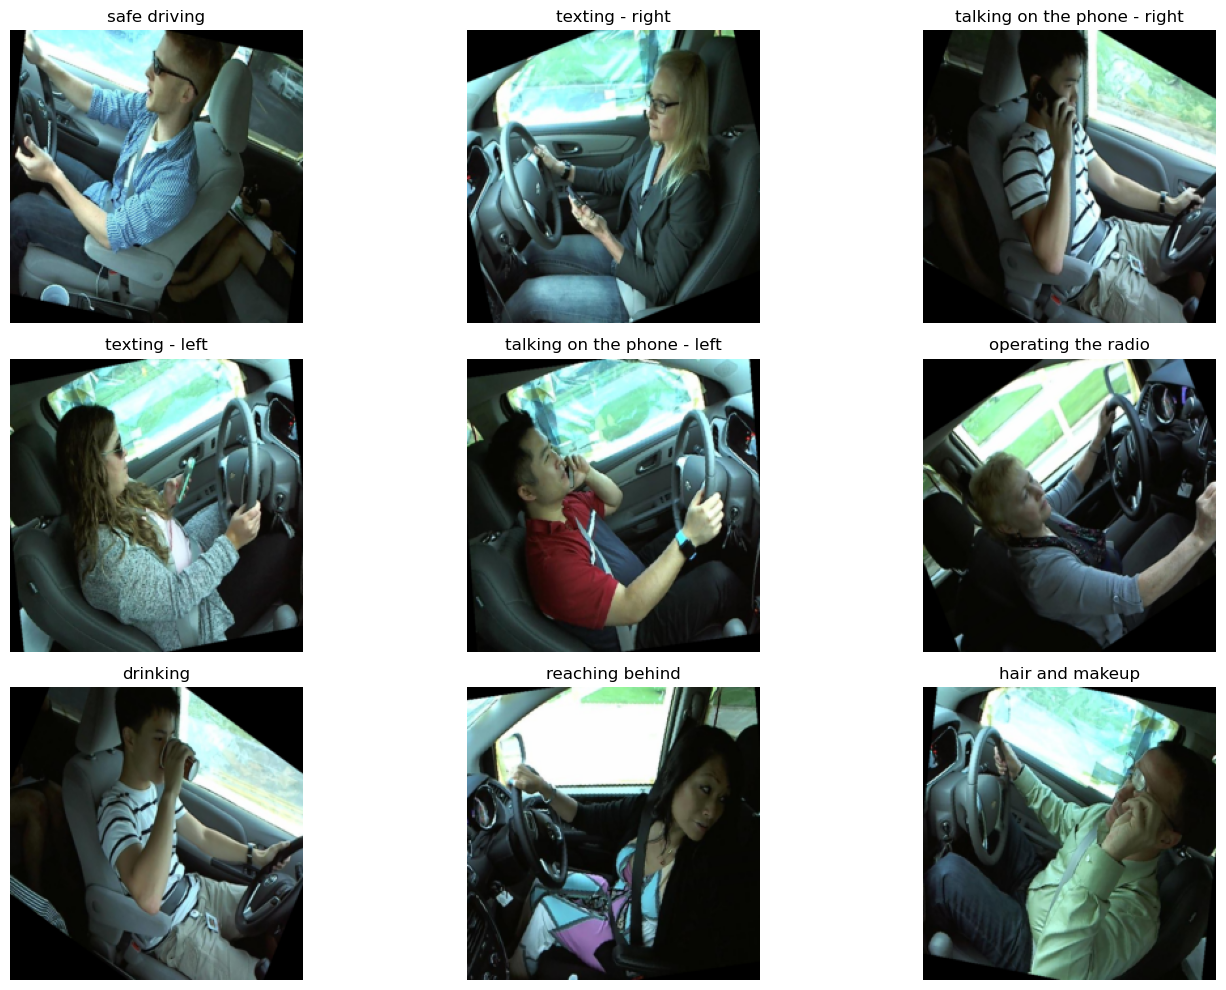

In [46]:
# Displaying training data including transformations
train_data.display_classes(id_to_class=True)

#### `Model`

In [47]:
''' A simple Convolution, Batch Normalization, and Activation Class'''

class ConvBnAct(nn.Module):
    
    def __init__(self, n_in, n_out, kernel_size = 3, stride = 1, 
                 padding = 0, groups = 1, bn = True, act = True,
                 bias = False
                ):
        
        super(ConvBnAct, self).__init__()
        
        self.conv = nn.Conv2d(n_in, n_out, kernel_size = kernel_size,
                              stride = stride, padding = padding,
                              groups = groups, bias = bias
                             )
        self.batch_norm = nn.BatchNorm2d(n_out) if bn else nn.Identity()
        self.activation = nn.SiLU() if act else nn.Identity()
        
    def forward(self, x):
        
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.activation(x)
        
        return x
    
#------------------------------------------------------------------------------

''' Squeeze and Excitation Block '''

class SqueezeExcitation(nn.Module):
    
    def __init__(self, n_in, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        
        
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(n_in, reduced_dim, kernel_size=1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, n_in, kernel_size=1),
            nn.Sigmoid()
        )
       
    def forward(self, x):
        
        y = self.se(x)
        
        return x * y
                                    
#------------------------------------------------------------------------------

''' Stochastic Depth Module'''

class StochasticDepth(nn.Module):
    
    def __init__(self, survival_prob = 0.8):
        super(StochasticDepth, self).__init__()
        
        self.p =  survival_prob
        
    def forward(self, x):
        
        if not self.training:
            return x
        
        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.p
        
        return torch.div(x, self.p) * binary_tensor
        
#-------------------------------------------------------------------------------

''' Residual Bottleneck Block with Expansion Factor = N as defined in Mobilenet-V2 paper
    with Squeeze and Excitation Block and Stochastic Depth. 
'''

class MBConvN(nn.Module):
    
    def __init__(self, n_in, n_out, kernel_size = 3, 
                 stride = 1, expansion_factor = 6,
                 reduction = 4, # Squeeze and Excitation Block
                 survival_prob = 0.8 # Stochastic Depth
                ):
        
        super(MBConvN, self).__init__()
        
        self.skip_connection = (stride == 1 and n_in == n_out) 
        intermediate_channels = int(n_in * expansion_factor)
        padding = (kernel_size - 1)//2
        reduced_dim = int(n_in//reduction)
        
        self.expand = nn.Identity() if (expansion_factor == 1) else ConvBnAct(n_in, intermediate_channels, kernel_size = 1)
        self.depthwise_conv = ConvBnAct(intermediate_channels, intermediate_channels,
                                        kernel_size = kernel_size, stride = stride, 
                                        padding = padding, groups = intermediate_channels
                                       )
        self.se = SqueezeExcitation(intermediate_channels, reduced_dim = reduced_dim)
        self.pointwise_conv = ConvBnAct(intermediate_channels, n_out, 
                                        kernel_size = 1, act = False
                                       )
        self.drop_layers = StochasticDepth(survival_prob = survival_prob)
        
    def forward(self, x):
        
        residual = x
        
        x = self.expand(x)
        x = self.depthwise_conv(x)
        x = self.se(x)
        x = self.pointwise_conv(x)
        
        if self.skip_connection:
            x = self.drop_layers(x)
            x += residual
        
        return x
    

#----------------------------------------------------------------------------------------------

'''Efficient-net Class'''

class EfficientNet(nn.Module):
    
    '''Generic Efficient net class which takes width multiplier, Depth multiplier, and Survival Prob.'''
    
    def __init__(self, width_mult = 1, depth_mult = 1, 
                 dropout_rate = 0.2, num_classes = 1000):
        super(EfficientNet, self).__init__()
        
        last_channel = ceil(1280 * width_mult)
        self.features = self._feature_extractor(width_mult, depth_mult, last_channel)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channel, num_classes)
        )
        
    def forward(self, x):
        
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x.view(x.shape[0], -1))
        
        return x
    
        
    def _feature_extractor(self, width_mult, depth_mult, last_channel):
        
        channels = 4*ceil(int(32*width_mult) / 4)
        layers = [ConvBnAct(3, channels, kernel_size = 3, stride = 2, padding = 1)]
        in_channels = channels
        
        kernels = [3, 3, 5, 3, 5, 5, 3]
        expansions = [1, 6, 6, 6, 6, 6, 6]
        num_channels = [16, 24, 40, 80, 112, 192, 320]
        num_layers = [1, 2, 2, 3, 3, 4, 1]
        strides =[1, 2, 2, 2, 1, 2, 1]
        
        # Scale channels and num_layers according to width and depth multipliers.
        scaled_num_channels = [4*ceil(int(c*width_mult) / 4) for c in num_channels]
        scaled_num_layers = [int(d * depth_mult) for d in num_layers]

        
        for i in range(len(scaled_num_channels)):
             
            layers += [MBConvN(in_channels if repeat==0 else scaled_num_channels[i], 
                               scaled_num_channels[i],
                               kernel_size = kernels[i],
                               stride = strides[i] if repeat==0 else 1, 
                               expansion_factor = expansions[i]
                              )
                       for repeat in range(scaled_num_layers[i])
                      ]
            in_channels = scaled_num_channels[i]
        
        layers.append(ConvBnAct(in_channels, last_channel, kernel_size = 1, stride = 1, padding = 0))
    
        return nn.Sequential(*layers)

In [48]:
# Compound scaling factors for efficient-net family.
efficient_net_config = {
    # tuple of width multiplier, depth multiplier, resolution, and Survival Prob
    "b0" : (1.0, 1.0, 224, 0.2),
    "b1" : (1.0, 1.1, 240, 0.2),
    "b2" : (1.1, 1.2, 260, 0.3),
    "b3" : (1.2, 1.4, 300, 0.3),
    "b4" : (1.4, 1.8, 380, 0.4),
    "b5" : (1.6, 2.2, 456, 0.4),
    "b6" : (1.8, 2.6, 528, 0.5),
    "b7" : (2.0, 3.1, 600, 0.5)
}

In [49]:
# Initialize Efficientnet model
version = 'b0'
width_mult, depth_mult, res, dropout_rate = 1., 1., 224, .5 # efficient_net_config[version]
model = EfficientNet(width_mult, depth_mult, dropout_rate, num_classes = 10)

In [50]:
batch_size = config['modeling_params']['batch_size']
epochs = 50 # config['modeling_params']['epochs']
seed = 42

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [51]:
# Model summary
x, y = next(iter(train_dataloader))

summary(model, input_size=x.shape)

Layer (type:depth-idx)                             Output Shape              Param #
EfficientNet                                       [32, 10]                  --
├─Sequential: 1-1                                  [32, 1280, 7, 7]          --
│    └─ConvBnAct: 2-1                              [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                            [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                       [32, 32, 112, 112]        64
│    │    └─SiLU: 3-3                              [32, 32, 112, 112]        --
│    └─MBConvN: 2-2                                [32, 16, 112, 112]        --
│    │    └─Identity: 3-4                          [32, 32, 112, 112]        --
│    │    └─ConvBnAct: 3-5                         [32, 32, 112, 112]        352
│    │    └─SqueezeExcitation: 3-6                 [32, 32, 112, 112]        552
│    │    └─ConvBnAct: 3-7                         [32, 16, 112, 112]        544
│    └─MBConvN: 2-3            

#### `Training Methods`

In [52]:
def visualize_training(history, num_epochs=50):
    
    # Generate Figure
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    # Loss Plots
    sns.lineplot(y=history['train_loss'], x=list(range(len(history['train_loss']))), ax=axs[0], label='Train Loss')
    sns.lineplot(y=history['val_loss'], x=list(range(len(history['val_loss']))), ax=axs[0], label='Validation Loss')
    axs[0].set_ylabel('Cross Entropy Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_xlim(0, num_epochs)

    # Accuracy Plots
    sns.lineplot(y=history['train_acc'], x=list(range(len(history['train_acc']))), ax=axs[1], label='Train Accuracy')
    sns.lineplot(y=history['val_acc'], x=list(range(len(history['val_acc']))), ax=axs[1], label='Validation Accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_xlim(0, num_epochs)
    
    # Show plot
    plt.show()

In [53]:
def train_step(model, dataloader, loss_fn,optimizer, device):
    """Train step for a single epoch. Taken from PyTorch 'Training with PyTorch'"""
    
    # Losses and accuracies
    train_loss, train_acc = 0, 0

    for i, data in enumerate(dataloader):
        
        # Extracting data and labels + moving to device
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)
        
        # Zero-ing gradients for every new batch
        optimizer.zero_grad()

        # Forward pass
        prediction = model(imgs)
        
        # Computing Loss and Gradient
        loss = loss_fn(prediction, labels)
        loss.backward()

        optimizer.step()

        # Update train loss and accuracy
        train_loss += loss.item()
        train_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return train loss and accuracy
    return train_loss / len(dataloader), train_acc / len(dataloader)


In [54]:
def validation(model, dataloader, loss_fn, device):
    """Validation loop"""
    # Setup validation loss and accuracy
    val_loss, val_acc = 0, 0

    # Disable gradient calculations
    with torch.no_grad():
        for i, data in enumerate(dataloader):   
            # Extract imgs and labels and sent to device
            imgs, labels = data
            imgs, labels  = imgs.to(device), labels.to(device)

            # Forward pass and update validation loss
            prediction = model(imgs)
            loss = loss_fn(prediction, labels)
            val_loss += loss.item()

            # Update validation accuracy
            val_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return validation loss and accuracy
    return val_loss / len(dataloader), val_acc / len(dataloader)

In [55]:
def save_model(model, model_name, epoch):
    """Function for saving model"""
    # Model name, with path
    timestamp = dt.datetime.now().strftime('%Y%m%d_%H%M%S')
    file = f'{model_name}_{timestamp}_epoch_{epoch+1}'
    name = os.path.join(config['outputs']['path'], model_name, file)
    
    # Make directory if not exists
    if not os.path.exists(os.path.join(os.path.join(config['outputs']['path'], model_name))):
        os.makedirs(os.path.join(os.path.join(config['outputs']['path'], model_name)))
    
    # Save model
    torch.save(model.state_dict(), f'{name}.pt')

In [56]:
class EarlyStopper:
    """Early Stopping Class. Copied from https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch"""
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            if self.counter != 0:
                print('Early Stopping Counter Reset')
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            print(f'Early Stopping Counter {self.counter} of {self.patience}')
            if self.counter >= self.patience:
                return True
        return False

In [57]:
def train(model, train_dataloader, validation_dataloader, optimizer, loss_fn, epochs, device, scheduler, early_stopping, model_name):
    """Model training method"""
    # History
    history = dict(train_loss=[],
                   train_acc=[],
                   val_loss=[],
                   val_acc=[])

    # Save start of training
    total_training_start = time.time()
    # Loop through epochs
    for epoch in range(epochs):
        print(f'\nEpoch {epoch+1} of {epochs} started...')
        
        # Get start training step time
        start_train = time.time()
        
        # Set model to train mode and do pass over data - plus save start of training step
        model.train(True)
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)

        # Set model to eval and do pass over validation data + time for start of validation step
        model.eval()
        val_loss, val_acc = validation(model, validation_dataloader, loss_fn, device)
        
        # Calculate total time spent
        end_train = time.time()
        total_m, total_s = divmod(end_train - start_train, 60)
        
        # lr Scheduler step
        if scheduler != None:
            scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1} of {epochs} ({round(total_m)}:{round(total_s)}) - Train loss: {train_loss:.5f} - Train acc: {train_acc:.5f} - Val loss: {val_loss:.5f} - Val acc: {val_acc:.5f}")
        
        
        # Save model if val loss is lower than previous lowest
        if val_loss < min(history['val_loss'], default=1e10):
            print(f"Saving model with new best val_loss: {val_loss:.5f}")
            
            # Save model
            save_model(model, model_name, epoch)
        
        # Save train and val loss/acc
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Visualize every 5th epoch
        if (epoch + 1) % 5 == 0: 
            visualize_training(history, epochs)
            
        if early_stopping.early_stop(val_loss):             
            print(f"Epoch {epoch+1} of {epochs} - Early stopping")
            print('Saving final model, with loss: ', val_loss)
            save_model(model, model_name, epoch)
            visualize_training(history, epoch+1)
            break
    total_training_end = time.time()
    minutes, seconds = divmod(total_training_end-total_training_start, 60)
    
    print(f'Total training time: {round(minutes)}:{round(seconds)}')
    return history


Epoch 1 of 50 started...
Epoch 1 of 50 (5:52) - Train loss: 2.14200 - Train acc: 0.18871 - Val loss: 1.72782 - Val acc: 0.28669
Saving model with new best val_loss: 1.72782

Epoch 2 of 50 started...
Epoch 2 of 50 (5:45) - Train loss: 1.32469 - Train acc: 0.49842 - Val loss: 0.99623 - Val acc: 0.61863
Saving model with new best val_loss: 0.99623

Epoch 3 of 50 started...
Epoch 3 of 50 (5:43) - Train loss: 0.73302 - Train acc: 0.74161 - Val loss: 1.12393 - Val acc: 0.61647
Early Stopping Counter 1 of 5

Epoch 4 of 50 started...
Epoch 4 of 50 (5:44) - Train loss: 0.48250 - Train acc: 0.83740 - Val loss: 1.19355 - Val acc: 0.69995
Early Stopping Counter 2 of 5

Epoch 5 of 50 started...
Epoch 5 of 50 (5:40) - Train loss: 0.36879 - Train acc: 0.87793 - Val loss: 0.86874 - Val acc: 0.72127
Saving model with new best val_loss: 0.86874


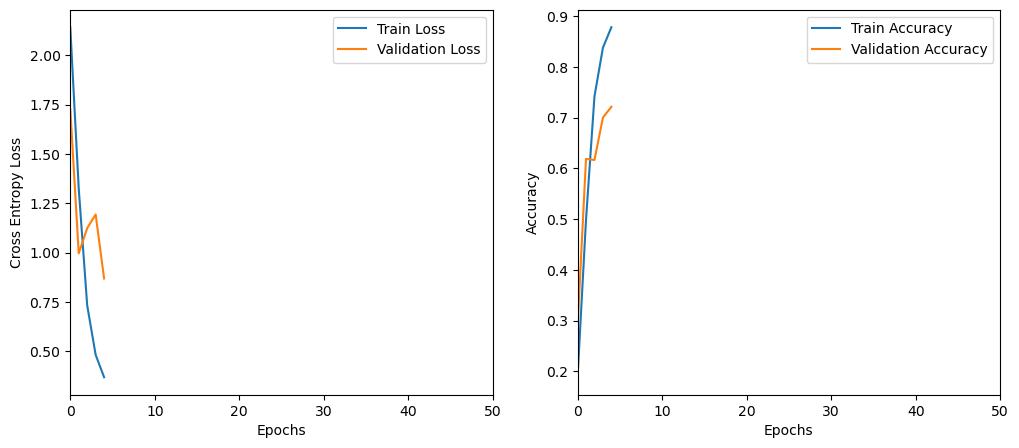

Early Stopping Counter Reset

Epoch 6 of 50 started...
Epoch 6 of 50 (5:37) - Train loss: 0.28409 - Train acc: 0.90835 - Val loss: 1.40374 - Val acc: 0.62901
Early Stopping Counter 1 of 5

Epoch 7 of 50 started...
Epoch 7 of 50 (5:35) - Train loss: 0.22990 - Train acc: 0.92612 - Val loss: 1.28981 - Val acc: 0.69359
Early Stopping Counter 2 of 5

Epoch 8 of 50 started...
Epoch 8 of 50 (5:33) - Train loss: 0.19813 - Train acc: 0.93596 - Val loss: 1.06074 - Val acc: 0.73043
Early Stopping Counter 3 of 5

Epoch 9 of 50 started...
Epoch 9 of 50 (37:41) - Train loss: 0.17263 - Train acc: 0.94663 - Val loss: 0.99776 - Val acc: 0.72332
Early Stopping Counter 4 of 5

Epoch 10 of 50 started...
Epoch 10 of 50 (5:22) - Train loss: 0.16312 - Train acc: 0.94701 - Val loss: 1.01477 - Val acc: 0.73645


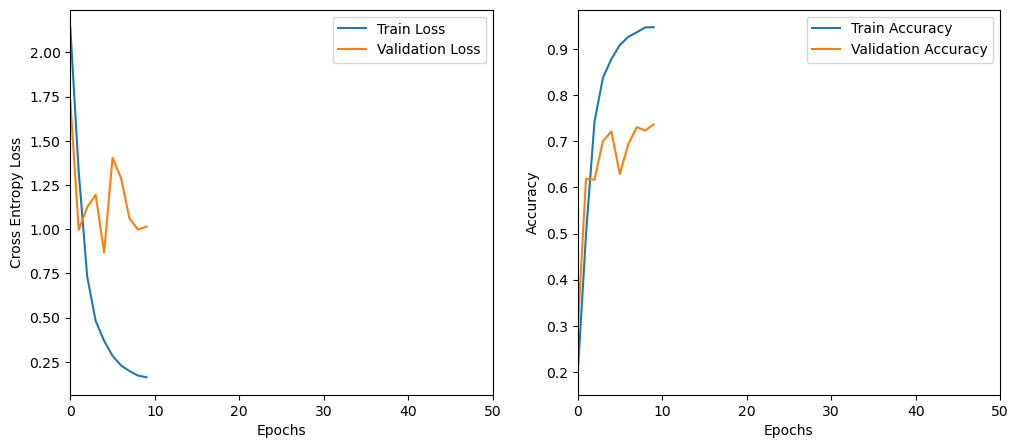

Early Stopping Counter 5 of 5
Epoch 10 of 50 - Early stopping
Saving final model, with loss:  1.014768246383894


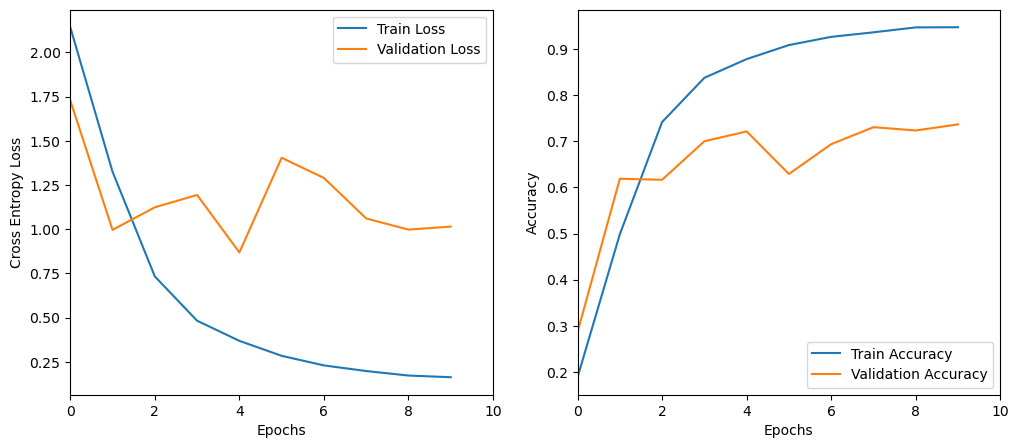

Total training time: 88:32


In [81]:
# Set random seeds
torch.manual_seed(42)

# Initialize Efficientnet model
version = 'b0'
width_mult, depth_mult, res, dropout_rate = efficient_net_config[version]
dropout_rate = .5
MODEL_NAME = 'EfficientNet_b0_AdamW'
model = EfficientNet(width_mult, depth_mult, dropout_rate, num_classes = 10)
model = model.to(device) # Load model to device.

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

# Setup scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       'min',
                                                       factor=.1,
                                                       patience=5,
                                                       min_lr=1e-7,
                                                       verbose=True)

early_stopping = EarlyStopper(patience=5, min_delta=.03)

# results
results = train(model=model,
                train_dataloader=train_dataloader,
                validation_dataloader=val_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=epochs,
                device=device,
                scheduler=scheduler,
                early_stopping=early_stopping,
                model_name=MODEL_NAME)

### Testing on Test Images

In [82]:
def test(model, dataloader, device):
    """Test loop"""
    # Setup test accuracy
    test_acc = 0
    model.eval()
    images = []
    classes = []
    predictions = []
    predictions_argmax = []
    
    # Disable gradient calculations
    with torch.no_grad():
        for i, data in enumerate(dataloader):   
            # Extract imgs and labels and sent to device
            imgs, labels = data
            images.append(imgs), classes.append(labels)
            
            imgs, labels  = imgs.to(device), labels.to(device)

            # Forward pass
            prediction = model(imgs)
            predictions.append(prediction)
            predictions_argmax.append(prediction.argmax(1))

            # Update test accuracy
            test_acc += (prediction.argmax(1) == labels).type(torch.float).mean().item()
    # Return test accuracy
    print(f'Test Accuracy {test_acc / len(dataloader)}')
    return images, classes, predictions, predictions_argmax

In [88]:
test_predictions = test(model=model,
                        dataloader=test_dataloader,
                        device=device)

Test Accuracy 0.7340534980650302


In [85]:
best_model = EfficientNet(width_mult, depth_mult, dropout_rate, num_classes = 10).to(device)
best_model.load_state_dict(torch.load('/Users/rasmuskrebs/Documents/School/semester_3/advanced_ml/aml_itu/outputs/EfficientNet_b0_AdamW/EfficientNet_b0_AdamW_20231204_093524_epoch_5.pt'))

<All keys matched successfully>

In [93]:
best_predictions = test(model=best_model,
                        dataloader=test_dataloader,
                        device=device)

Test Accuracy 0.7304205248753229
